In [1]:
pip install scripts

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
from keras.src.saving.saving_api import load_model
from keras.src.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.src.utils.numerical_utils import to_categorical
from sklearn.metrics import accuracy_score
from PIL import Image
import tensorflow as tf
from skimage import feature
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import logging
from ast import literal_eval
import csv

import matplotlib.pyplot as plt

In [2]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',      
            2:'Speed limit (50km/h)',       
            3:'Speed limit (60km/h)',      
            4:'Speed limit (70km/h)',    
            5:'Speed limit (80km/h)',      
            6:'End of speed limit (80km/h)',     
            7:'Speed limit (100km/h)',    
            8:'Speed limit (120km/h)',     
           9:'No passing',   
           10:'No passing veh over 3.5 tons',     
           11:'Right-of-way at intersection',     
           12:'Priority road',    
           13:'Yield',     
           14:'Stop',       
           15:'No vehicles',       
           16:'Veh > 3.5 tons prohibited',       
           17:'No entry',       
           18:'General caution',     
           19:'Dangerous curve left',      
           20:'Dangerous curve right',   
           21:'Double curve',      
           22:'Bumpy road',     
           23:'Slippery road',       
           24:'Road narrows on the right',  
           25:'Road work',    
           26:'Traffic signals',      
           27:'Pedestrians',     
           28:'Children crossing',     
           29:'Bicycles crossing',       
           30:'Beware of ice/snow',
           31:'Wild animals crossing',      
           32:'End speed + passing limits',      
           33:'Turn right ahead',     
           34:'Turn left ahead',       
           35:'Ahead only',      
           36:'Go straight or right',      
           37:'Go straight or left',      
           38:'Keep right',     
           39:'Keep left',      
           40:'Roundabout mandatory',     
           41:'End of no passing',      
           42:'End no passing veh > 3.5 tons' }

# Hàm trích xuất đặc trưng

In [4]:
def compute_hog(image_path):
    try:
        image = Image.open(image_path)
        image = image.convert("L")
        image = image.resize((224, 224))

        hog, _ = feature.hog(np.array(image), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             visualize=True, transform_sqrt=True, block_norm='L2-Hys')
        return hog
    except Exception as e:
        logging.error(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

# Thử với 1 ảnh

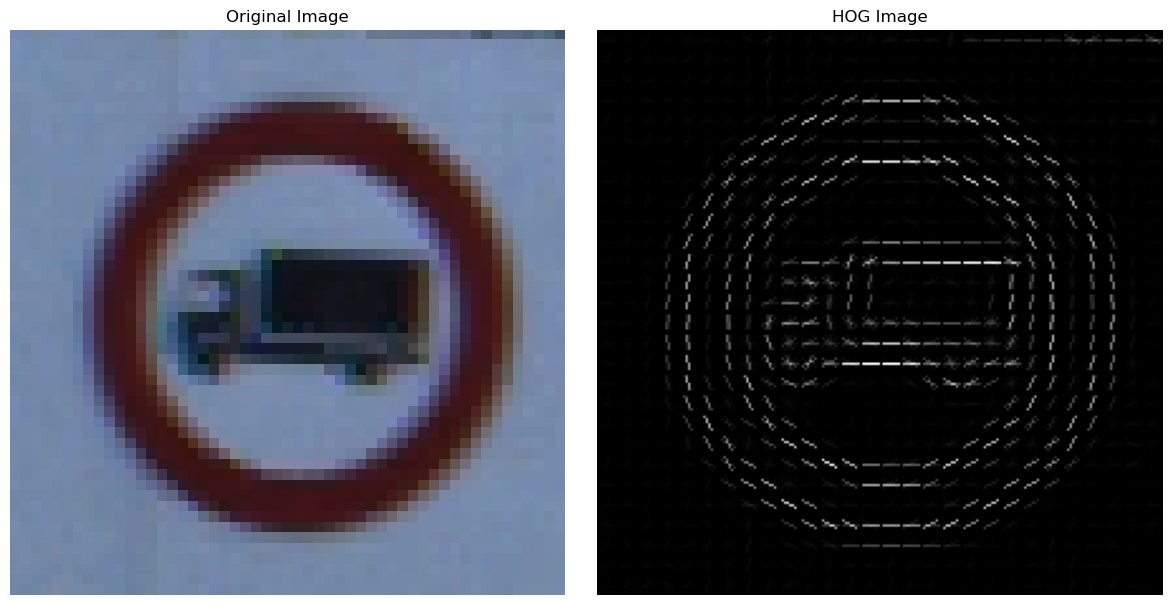

Kích thước của HOG features cho ảnh: (26244,)


In [5]:
def test_compute_hog(image_path):
    try:
        image = Image.open(image_path)
        image = image.convert("L")
        image = image.resize((224, 224))

        hog, _ = feature.hog(np.array(image), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             visualize=True, transform_sqrt=True, block_norm='L2-Hys')
        return hog, _
    except Exception as e:
        logging.error(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

# Đường dẫn tới thư mục chứa ảnh
image_folder = './test/'

# Tên file ảnh cần thử nghiệm
image_filename = "00000.png"

# Khởi tạo danh sách lưu trữ HOG features và hình ảnh
features = []
hog_images = []
original_images = []

# Tính toán HOG features và HOG images cho ảnh
image_path = os.path.join(image_folder, image_filename)
hog_feature, hog_image = test_compute_hog(image_path)
features.append(hog_feature)
hog_images.append(hog_image)
original_images.append(Image.open(image_path))

# Hiển thị hình ảnh gốc và HOG image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_images[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_images[0], cmap=plt.cm.gray)
plt.title('HOG Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# In ra kích thước của HOG features cho ảnh
print(f"Kích thước của HOG features cho ảnh: {np.array(features[0]).shape}")


# Thử hàm trích xuất đặc trưng và lưu

In [8]:
def write_batch_to_csv(data, labels, output_file, mode='a'):
    with open(output_file, mode, newline='') as file:
        writer = csv.writer(file)
        if mode == 'w':  # Chỉ viết header nếu ở chế độ ghi mới
            writer.writerow(['X_test_pre', 'y_test_pre'])
        for hog_feat, label in zip(data, labels):
            writer.writerow([hog_feat.tolist(), label])

In [9]:
def load_data_from_csv(csv_file, batch_size=3000, output_file='pre_test_data.csv'):
    data = []
    labels = []
    start_index = 0

    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        total_lines = len(lines)
        
        for i, line in enumerate(lines):
            parts = line.strip().split(',')
            image_path = parts[-1]
            try:
                hog = compute_hog(image_path)
                if hog is not None:
                    data.append(hog)
                    labels.append(int(parts[-2]))  # ClassId là phần thứ 2 từ cuối dòng
            except Exception as e:
                logging.error(f"Lỗi khi tải ảnh {image_path}: {e}")

            if (i + 1) % batch_size == 0 or (i + 1) == total_lines:
                try:
                    if start_index == 0:  # Batch đầu tiên
                        write_batch_to_csv(data, labels, output_file, mode='w')
                    else:
                        write_batch_to_csv(data, labels, output_file, mode='a')
                    logging.info(f"Đã xử lý và lưu {i + 1} ảnh")
                except Exception as e:
                    logging.error(f"Lỗi khi ghi batch vào CSV: {e}")
                    return start_index

                data = []
                labels = []
                start_index = i + 1

    return start_index

In [10]:
# Tải dữ liệu từ CSV và xử lý theo từng batch
last_processed_index = load_data_from_csv('Test_pre.csv')
print(f"Số thứ tự ảnh cuối cùng được xử lý: {last_processed_index}")

Số thứ tự ảnh cuối cùng được xử lý: 9


In [23]:
def read_data_from_csv(input):
    csv.field_size_limit(2**31 - 1)
    data = []
    labels = []
    with open(input, 'r') as file:
        reader = csv.reader(file)
        next(reader) # Skip title
        for row in reader:
            hog = np.array(literal_eval(row[0])) # Chuyển str -> list
            label = int(row[1])
            data.append(hog)
            labels.append(label)
    return np.array(data), np.array(labels)

In [24]:
X_pre_test, y_pre_test = read_data_from_csv('pre_test_data.csv')

In [25]:
X_pre_test

array([[0.42652041, 0.        , 0.        , ..., 0.12181327, 0.14014267,
        0.22569061],
       [0.        , 0.        , 0.        , ..., 0.25510671, 0.12109529,
        0.        ],
       [0.32668931, 0.        , 0.06600121, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3611454 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02965221, 0.1152552 ,
        0.06461747],
       [0.42808217, 0.        , 0.        , ..., 0.05773038, 0.22282948,
        0.29972859]])

In [26]:
len(X_pre_test)

9

In [27]:
len(y_pre_test)

9

# Trích xuất đặc trưng từ ảnh training

In [11]:
def write_batch_to_csv(data, labels, output_file, mode='a'):
    with open(output_file, mode, newline='') as file:
        writer = csv.writer(file)
        if mode == 'w':  # Chỉ viết header nếu ở chế độ ghi mới
            writer.writerow(['X_train', 'y_train'])
        for hog_feat, label in zip(data, labels):
            writer.writerow([hog_feat.tolist(), label])

In [12]:
def load_data_from_csv(csv_file, batch_size=3000, output_file='train_data.csv'):
    data = []
    labels = []
    start_index = 0

    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        total_lines = len(lines)
        
        for i, line in enumerate(lines):
            parts = line.strip().split(',')
            image_path = parts[-1]
            try:
                hog = compute_hog(image_path)
                if hog is not None:
                    data.append(hog)
                    labels.append(int(parts[-2]))  # ClassId là phần thứ 2 từ cuối dòng
            except Exception as e:
                logging.error(f"Lỗi khi tải ảnh {image_path}: {e}")

            if (i + 1) % batch_size == 0 or (i + 1) == total_lines:
                try:
                    if start_index == 0:  # Batch đầu tiên
                        write_batch_to_csv(data, labels, output_file, mode='w')
                    else:
                        write_batch_to_csv(data, labels, output_file, mode='a')
                    logging.info(f"Đã xử lý và lưu {i + 1} ảnh")
                except Exception as e:
                    logging.error(f"Lỗi khi ghi batch vào CSV: {e}")
                    return start_index

                data = []
                labels = []
                start_index = i + 1

    return start_index

In [14]:
# Tải dữ liệu từ CSV và xử lý theo từng batch
last_processed_index = load_data_from_csv('Train.csv')
print(f"Số thứ tự ảnh cuối cùng được xử lý: {last_processed_index}")

Số thứ tự ảnh cuối cùng được xử lý: 39209


# Tương tự với các ảnh test

In [37]:
def write_batch_to_csv(data, labels, output_file, mode='a'):
    with open(output_file, mode, newline='') as file:
        writer = csv.writer(file)
        if mode == 'w':  # Chỉ viết header nếu ở chế độ ghi mới
            writer.writerow(['X_test', 'y_test'])
        for hog_feat, label in zip(data, labels):
            writer.writerow([hog_feat.tolist(), label])

In [38]:
def load_data_from_csv(csv_file, batch_size=3000, output_file='test_data.csv'):
    data = []
    labels = []
    start_index = 0

    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        total_lines = len(lines)
        
        for i, line in enumerate(lines):
            parts = line.strip().split(',')
            image_path = parts[-1]
            try:
                hog = compute_hog(image_path)
                if hog is not None:
                    data.append(hog)
                    labels.append(int(parts[-2]))  # ClassId là phần thứ 2 từ cuối dòng
            except Exception as e:
                logging.error(f"Lỗi khi tải ảnh {image_path}: {e}")

            if (i + 1) % batch_size == 0 or (i + 1) == total_lines:
                try:
                    if start_index == 0:  # Batch đầu tiên
                        write_batch_to_csv(data, labels, output_file, mode='w')
                    else:
                        write_batch_to_csv(data, labels, output_file, mode='a')
                    logging.info(f"Đã xử lý và lưu {i + 1} ảnh")
                except Exception as e:
                    logging.error(f"Lỗi khi ghi batch vào CSV: {e}")
                    return start_index

                data = []
                labels = []
                start_index = i + 1

    return start_index

In [39]:
# Tải dữ liệu từ CSV và xử lý theo từng batch
last_processed_index = load_data_from_csv('Test.csv')
print(f"Số thứ tự ảnh cuối cùng được xử lý: {last_processed_index}")

Số thứ tự ảnh cuối cùng được xử lý: 12630


In [10]:
from sklearn import svm

# Khởi tạo và huấn luyện mô hình SVM
model = svm.LinearSVC(C=0.01)
model.fit(X_train, y_train)

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.01)

In [12]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Tính toán độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy * 100:.2f}%")


Độ chính xác của mô hình: 98.44%


In [14]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train) 

KNeighborsClassifier()

In [15]:
# Dự đoán trên tập kiểm tra
y_pred = model_knn.predict(X_test)

# Tính toán độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy * 100:.2f}%")

Độ chính xác của mô hình: 94.36%


In [17]:
from joblib import dump

# Lưu mô hình KNeighborsClassifier
dump(model_knn, 'model_knn.joblib')

# Lưu mô hình SVM
dump(model, 'model_svm.joblib')

['model_svm.joblib']

In [18]:
from joblib import load

# Tải lại mô hình KNeighborsClassifier từ tệp
loaded_model_knn = load('model_knn.joblib')

# Tải lại mô hình SVM từ tệp
loaded_model_svm = load('model_svm.joblib')

In [27]:
def predict_and_show(image_path, model_path):
    # Tính toán HOG cho ảnh 1
    hog, hog_image = compute_hog(image_path)

    # Load mô hình
    model = load(model_path)

    # Dự đoán nhãn cho ảnh 1 và ảnh 2
    label = model.predict([hog])[0]

    # Hiển thị ảnh 1 và ảnh 2 cùng với nhãn gốc và nhãn dự đoán
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    image = Image.open(image_path)
    axes[0].imshow(image)
    axes[0].set_title(f"Nhãn dự đoán: {classes[label]}")

    # image2 = Image.open(image2_path)
    axes[1].imshow(hog_image)
    axes[1].set_title(f"Ảnh HOG")

    plt.show()

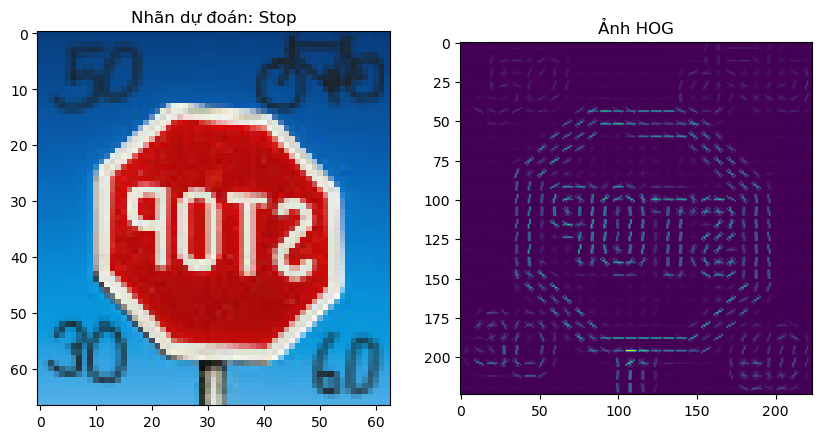

In [38]:
# Đường dẫn đến ảnh 1 và ảnh 2
image_path = "d.png"

# Đường dẫn đến mô hình đã huấn luyện
model_path = "model_knn.joblib"

# Dự đoán và hiển thị
predict_and_show(image_path, model_path)

In [ ]:
# Tạo DataFrame từ dữ liệu
df = pd.DataFrame({
    'hog_features': X_train_img,
    'labels': y_train
})

# Lưu DataFrame vào tệp CSV
df.to_csv('data.csv', index=False)
print("Dữ liệu đã được lưu vào tệp data.csv")

Dữ liệu đã được lưu vào tệp data.csv


# Đọc tệp CSV vào DataFrame

In [ ]:
df = pd.read_csv('data.csv')
print(df.head())
hog_features = df['hog_features'].values
labels = df['labels'].values

                                        hog_features  labels
0  [0.42652041 0.         0.         ... 0.121813...      20
1  [0.         0.         0.         ... 0.255106...      20
2  [0.32668931 0.         0.06600121 ... 0.      ...      20
3                            [0. 0. 0. ... 0. 0. 0.]      20
4                            [0. 0. 0. ... 0. 0. 0.]      20


In [ ]:
print('Đặc trưng ảnh: ', hog_features[0])
print('Nhãn: ', labels[0])

Đặc trưng ảnh:  [0.42652041 0.         0.         ... 0.12181327 0.14014267 0.22569061]
Nhãn:  20
